In [ ]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/a1/f6/57de91ea40c670527cd47a6548bf2cbedc68cec57c041793b256356abad7/opencv_python-4.8.1.78-cp37-abi3-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for numpy>=1.21.0 from https://files.pythonhosted.org/packages/20/be/46eed58d8ca60cfd0c4f3c6db3db79955f6de7d434db0f49fed2f817a6a4/numpy-1.26.2-cp39-cp39-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 26.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 33.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/5c/98/211647fc6aa89355c11b028f37ceae95d7e1bbb99ac363cbf4c4297ef4d7/matplotlib-3.8.2-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/8a/b8/258adec810e0c4c28292ad1af5736809d393587bd88e79635343fcdc78d0/contourpy-1.2.0-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/2b/ff/8c9b05fd2bbdfe6fee7c0e8a3e8981b4454404dca3ef58fc98a6673a6cf8/fonttools-4.46.0-cp39-cp39-macosx_10_9_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 3.7 MB/s eta 0:00:0000:01
  Obtaining dependency informatio

Available labels: ['2D', '3D', 'R_cam_2_world', 'cam', 'cam_intrinsic', 'cam_position', 'frame', 'seq', 'subj']


/var/folders/bn/rp341_sd695dyt29c8xyybpw0000gn/T/ipykernel_54881/2465153111.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_name)


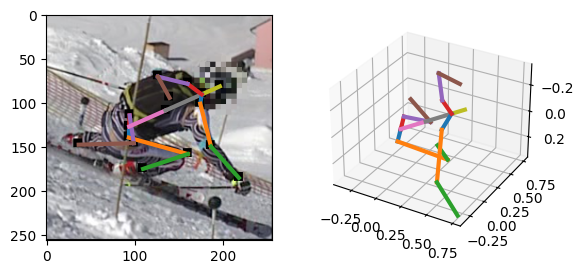

In [ ]:
import numpy as np
import h5py
import imageio
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# joint indice description
joint_names_h36m = ['hip','right_up_leg','right_leg','right_foot','left_up_leg',
                    'left_leg', 'left_foot','spine1','neck', 'head','head-top',
                    'left-arm','left_forearm','left_hand','right_arm',
                    'right_forearm','right_hand']
bones_h36m = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6], [0, 7],
              [7, 8], [8, 9], [9, 10], [8, 14], [14, 15], [15, 16],
              [8, 11], [11, 12], [12, 13]]

# load label data
h5_label_file = h5py.File('/Users/alexandrzvonarev/PycharmProjects/pythonProject/Ski-PosePTZ-CameraDataset-png/test/labels.h5', 'r')
print('Available labels:',list(h5_label_file.keys()))

# load the 100th example
index = 0
seq   = int(h5_label_file['seq'][index])
cam   = int(h5_label_file['cam'][index])
frame = int(h5_label_file['frame'][index])
subj  = int(h5_label_file['subj'][index])
pose_3D = h5_label_file['3D'][index].reshape([-1,3])
pose_2D = h5_label_file['2D'][index].reshape([-1,2]) # in range 0..1
pose_2D_px = 256*pose_2D # in pixels, range 0..255

# camera parameters (unused here)
camera_intrinsic     = h5_label_file['cam_intrinsic'][index].reshape([-1,3])
camera_position      = h5_label_file['cam_position'][index]
camera_R_cam_2_world = h5_label_file['R_cam_2_world'][index].reshape([3,3])

# load image
image_name = '/Users/alexandrzvonarev/PycharmProjects/pythonProject/Ski-PosePTZ-CameraDataset-png/test/seq_{:03d}/cam_{:02d}/image_{:06d}.png'.format(seq,cam,frame)
img = imageio.imread(image_name)

# mark the 17 joint locations with black dots
for point in pose_2D_px:
    img[int(point[1])-5:int(point[1])+5, int(point[0])-5:int(point[0])+5, :] = 0

# display image and overlayed 2D labels
fig = plt.figure(0)
ax_2D = fig.add_subplot(121)
ax_2D.imshow(img)
for bone in bones_h36m:
    ax_2D.plot(pose_2D_px[bone,0], pose_2D_px[bone,1], linewidth=3)

# display 3D pose
ax_3D = fig.add_subplot(122, projection='3d')
for bone in bones_h36m:
    ax_3D.plot(pose_3D[bone,0], pose_3D[bone,2], pose_3D[bone,1], linewidth=3)
ax_3D.invert_zaxis()
plt.show()


In [ ]:
def calculate_angle(point1: np.ndarray,
                    point2: np.ndarray,
                    point3: np.ndarray
                    ) -> float:
    """
    Args:
        point1: numpy.ndarray (1D, size 3) -
        Coordinates of the first point (x, y, z).
        point2: numpy.ndarray (1D, size 3) -
        Coordinates of the second point (x, y, z).
        point3: numpy.ndarray (1D, size 3) -
        Coordinates of the third point (x, y, z).

    Returns:
        float - The angle in degrees between the three points.
    """
    a = np.array(point1)
    b = np.array(point2)
    c = np.array(point3)

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

def calculate_back_leg_angle(pose_3D: np.ndarray,
                             hip_joint_index: int,
                             spine_joint_index: int,
                             knee_joint_index: int) -> float:
    """
    Args:
        pose_3D: numpy.ndarray -
        Array of joint positions in 3D space (shape: [17, 3]).
        hip_joint_index: int -
        Index of the hip joint in the joint_names_h36m list.
        spine_joint_index: int -
        Index of the spine joint in the joint_names_h36m list.
        knee_joint_index: int -
        Index of the knee joint in the joint_names_h36m list.

    Returns:
        float - The angle between the hip, spine, and knee joints.
    """
    hip_joint = pose_3D[hip_joint_index]
    spine_joint = pose_3D[spine_joint_index]
    knee_joint = pose_3D[knee_joint_index]

    # Calculate the angle
    angle = calculate_angle(spine_joint, hip_joint, knee_joint)
    return angle

In [ ]:
h5_label_file = h5py.File('/Users/alexandrzvonarev/PycharmProjects/pythonProject/Ski-PosePTZ-CameraDataset-png/train/labels.h5', 'r')

right_leg_train = []
back_leg_train = []

# Iterate through all data points
for index in range(len(h5_label_file['seq'])):
    seq = int(h5_label_file['seq'][index])
    cam = int(h5_label_file['cam'][index])
    frame = int(h5_label_file['frame'][index])
    subj = int(h5_label_file['subj'][index])
    pose_3D = h5_label_file['3D'][index].reshape([-1, 3])

    # Calculate angles for right leg
    right_leg_angle = calculate_angle(pose_3D[bones_h36m[1][0]],
                                      pose_3D[bones_h36m[1][1]],
                                      pose_3D[bones_h36m[2][1]])
    right_leg_train.append(right_leg_angle)


    hip_joint_index = joint_names_h36m.index('hip')
    spine_joint_index = joint_names_h36m.index('spine1')
    knee_joint_index = joint_names_h36m.index('right_leg')  # or 'left_leg'

    # Calculate the angle
    back_leg_angle = calculate_back_leg_angle(pose_3D,
                                              bones_h36m,
                                              hip_joint_index,
                                              spine_joint_index,
                                              knee_joint_index)
    back_leg_train.append(back_leg_angle)

# Close the H5 file
h5_label_file.close()



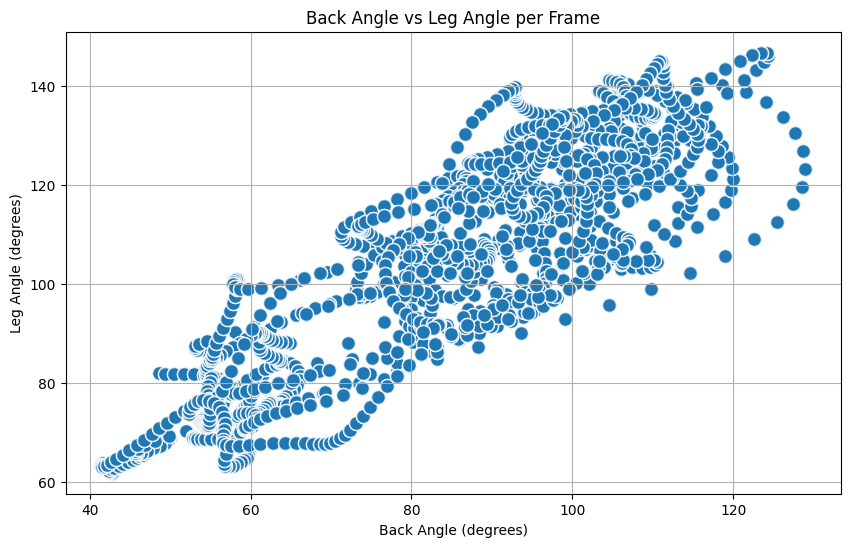

In [ ]:
# Scatter plot of back angle vs leg angle
plt.figure(figsize=(10, 6))
plt.scatter(back_leg_train, right_leg_train, alpha=0.6, edgecolors='w', s=100)
plt.title('Back Angle vs Leg Angle per Frame')
plt.xlabel('Back Angle (degrees)')
plt.ylabel('Leg Angle (degrees)')
plt.grid(True)
plt.show()


In [ ]:
def plot_angles_over_time(back_angles: list[float],
                          leg_angles: list[float],
                          frames: list[int],
                          title: str = 'Angle Change Over Time') -> None:
    """

    """
    Args:
        back_angles: list of float - List of back angles for each frame.
        leg_angles: list of float - List of leg angles for each frame.
        frames: list of int - List of frame indices.
        title: str - Title of the plot.

    """

    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the back angle
    color = 'tab:red'
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Back Angle (degrees)', color=color)
    ax1.plot(frames, back_angles, color=color, label='Back Angle')
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot the leg angle
    color = 'tab:blue'
    ax2.set_ylabel('Leg Angle (degrees)', color=color)
    ax2.plot(frames, leg_angles, color=color, label='Leg Angle')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add a title
    plt.title(title)

    # Show plot with a legend
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

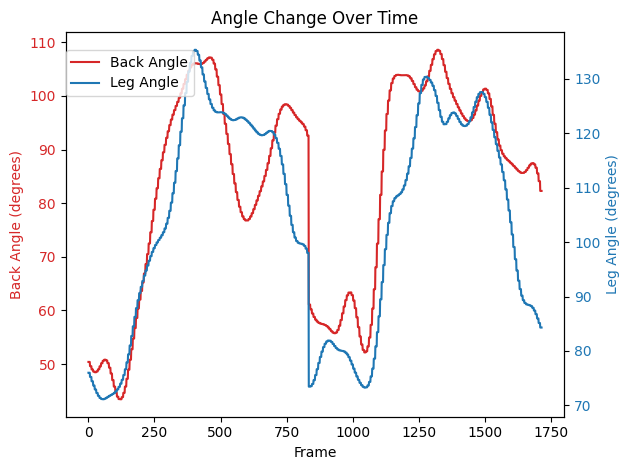

In [ ]:
h5_label_file = h5py.File('/Users/alexandrzvonarev/PycharmProjects/pythonProject/Ski-PosePTZ-CameraDataset-png/train/labels.h5', 'r')

right_leg_train = []
back_leg_train = []
frame_indices = []

# Iterate through all data points
for index in range(len(h5_label_file['seq'])):
    seq = int(h5_label_file['seq'][index])
    cam = int(h5_label_file['cam'][index])
    frame = int(h5_label_file['frame'][index])
    subj = int(h5_label_file['subj'][index])
    pose_3D = h5_label_file['3D'][index].reshape([-1, 3])

    # Calculate angles for right leg
    right_leg_angle = calculate_angle(pose_3D[bones_h36m[1][0]],
                                      pose_3D[bones_h36m[1][1]],
                                      pose_3D[bones_h36m[2][1]])
    right_leg_train.append(right_leg_angle)


    hip_joint_index = joint_names_h36m.index('hip')
    spine_joint_index = joint_names_h36m.index('spine1')
    knee_joint_index = joint_names_h36m.index('right_leg')  # or 'left_leg'

    # Calculate the angle
    back_leg_angle = calculate_back_leg_angle(pose_3D,
                                              bones_h36m,
                                              hip_joint_index,
                                              spine_joint_index,
                                              knee_joint_index)
    back_leg_train.append(back_leg_angle)
    frame_indices.append(index)

plot_angles_over_time(back_leg_train, right_leg_train, frame_indices)

# Close the H5 file
h5_label_file.close()



In [ ]:
def create_dataset(data: np.ndarray,
                   time_steps: int = 1) -> tuple[np.ndarray, np.ndarray]:
  """
    Args:
        data: numpy.ndarray -
        2D array where each column is a feature (back angle, leg angle).
        time_steps: int - Number of time steps to look back.

    Returns:
        dataX: numpy.ndarray -
        3D array of shape (samples, time_steps, features).
        dataY: numpy.ndarray - 2D array of shape (samples, features).
    """
    dataX, dataY = [], []
    for i in range(len(data) - time_steps - 1):
        a = data[i:(i + time_steps), :]
        dataX.append(a)
        dataY.append(data[i + time_steps, :])
    return np.array(dataX), np.array(dataY)

data = np.column_stack((back_leg_train, right_leg_train))
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

time_steps = 5
X, y = create_dataset(data, time_steps)

train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape the input data to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, 2))
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 2))

model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, 2), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(2))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions and targets to their original scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print('Train RMSE: {:.2f}'.format(train_rmse))
print('Test RMSE: {:.2f}'.format(test_rmse))


Epoch 1/20
5678/5678 [==============================] - 10s 2ms/step - loss: 0.0015
Epoch 2/20
5678/5678 [==============================] - 9s 2ms/step - loss: 5.3833e-04
Epoch 3/20
5678/5678 [==============================] - 8s 1ms/step - loss: 4.0519e-04
Epoch 4/20
5678/5678 [==============================] - 9s 2ms/step - loss: 3.1633e-04
Epoch 5/20
5678/5678 [==============================] - 11s 2ms/step - loss: 3.0611e-04
Epoch 6/20
5678/5678 [==============================] - 9s 2ms/step - loss: 2.6345e-04
Epoch 7/20
5678/5678 [==============================] - 9s 2ms/step - loss: 2.7745e-04
Epoch 8/20
5678/5678 [==============================] - 9s 2ms/step - loss: 2.6776e-04
Epoch 9/20
5678/5678 [==============================] - 8s 1ms/step - loss: 2.5327e-04
Epoch 10/20
5678/5678 [==============================] - 8s 1ms/step - loss: 2.6513e-04
Epoch 11/20
5678/5678 [==============================] - 8s 1ms/step - loss: 2.4271e-04
Epoch 12/20
5678/5678 [====================

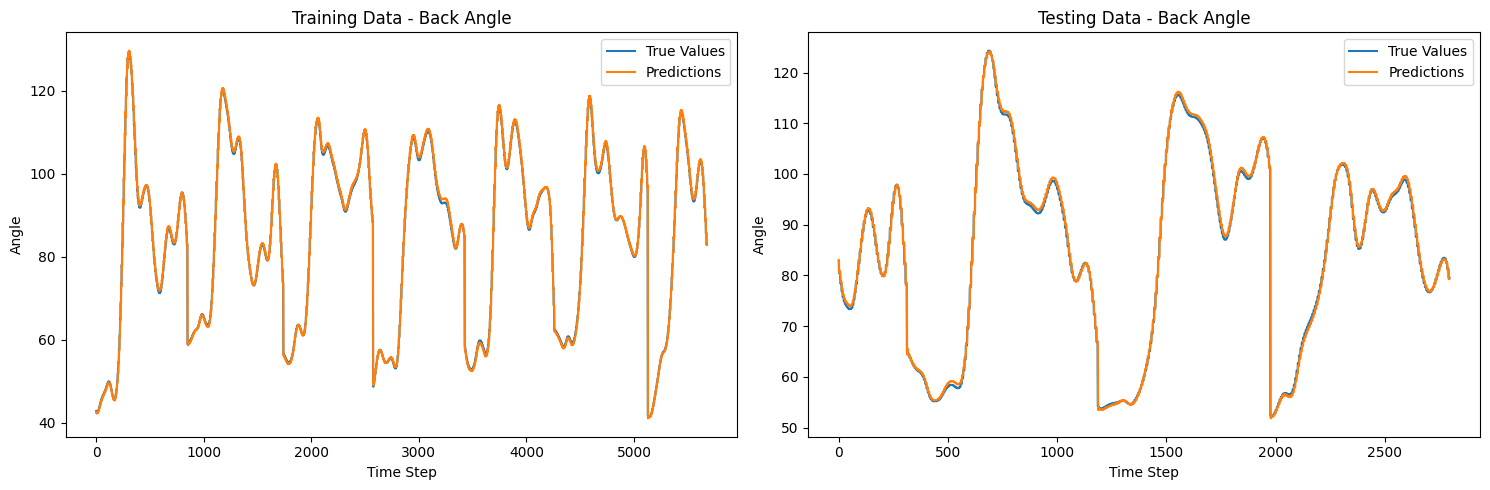

In [ ]:
plt.figure(figsize=(15, 5))

# Plot training data
plt.subplot(1, 2, 1)
plt.plot(y_train[:, 0], label='True Values')
plt.plot(train_predict[:, 0], label='Predictions')
plt.title('Training Data - Back Angle')
plt.xlabel('Time Step')
plt.ylabel('Angle')
plt.legend()

# Plot testing data
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 0], label='True Values')
plt.plot(test_predict[:, 0], label='Predictions')
plt.title('Testing Data - Back Angle')
plt.xlabel('Time Step')
plt.ylabel('Angle')
plt.legend()

plt.tight_layout()
plt.show()